In [1]:
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 09:23:15) 
[Clang 10.0.1 (clang-1001.0.46.3)]


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import requests
import sys
import seaborn as sns; sns.set()
from argparse import Namespace
from collections import Counter, namedtuple
from lxml import etree
from tqdm import tqdm_notebook as tqdm

In [3]:
from abstracts import fetch_abstracts

In [4]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [5]:
def top_k(vec, dictionary, k=20):
    for k,v in sorted(vec, key=lambda x: -x[1])[:k]:
        print(f'{dictionary[k]:>20}   {v}')

# Read abstracts from PubMed API

In [6]:
filename = '../data/pmids_gold_set_labeled.txt'
labeled_set = pd.read_csv(filename, sep='\t', names=['pmid', 'topic'])

In [170]:
articles = fetch_abstracts(labeled_set.pmid)
print(len(articles))

103


# Look at most common words

In [8]:
import gensim
from gensim import corpora
from gensim import models
from gensim import utils
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, remove_stopwords
from gensim.models.coherencemodel import CoherenceModel

Convert titles/abstracts into lists of individual words, filtering out stop words

In [9]:
texts = [
    (remove_stopwords(a.title.lower()).split() +
     remove_stopwords(a.abstract.lower()).split())
    for a in articles
]

In [10]:
counts = Counter(w for t in texts for w in t)

In [11]:
len(counts)

4196

How many words occur more than once in the corpus?

In [12]:
sum(n>1 for w,n in counts.items())

1646

In [13]:
counts.most_common(20)

[('cystic', 124),
 ('breast', 121),
 ('patients', 115),
 ('cancer', 85),
 ('fibrosis', 84),
 ('clinical', 80),
 ('treatment', 72),
 ('disease', 66),
 ('osteogenesis', 53),
 ('mutations', 51),
 ('genetic', 48),
 ('triple-negative', 47),
 ('expression', 38),
 ('tnbc', 38),
 ('bone', 38),
 ('bbs', 38),
 ('tumor', 37),
 ('type', 36),
 ('gene', 35),
 ('negative', 34)]

In [14]:
print(counts['tnbc'],counts['(tnbc)'],counts['(tnbc),'])

38 12 1


In [15]:
[(w,n) for w,n in counts.items() if '-' in w][:10]

[('triple-negative', 47),
 ('er-positive,', 1),
 ('her2-positive', 1),
 ('mir-26b,', 3),
 ('up-regulation', 1),
 ('up-regulated', 1),
 ('over-expression', 1),
 ('up-regulating', 1),
 ('gper-1.', 1),
 ('17β-oestradiol', 1)]

# Preprocess

In [16]:
medical_stopwords = {'patient', 'patients', 'clinical', 'treatment', 'disease',
                     'present', 'new', 'diagnosis', 'disorder', 'disorders', 'associated'}
STOPWORDS = gensim.parsing.preprocessing.STOPWORDS | medical_stopwords

In [17]:
def remove_stopwords(s):
    s = utils.to_unicode(s)
    return " ".join(w for w in s.split() if w not in STOPWORDS)

In [18]:
filters = [
    lambda x: x.lower(),
    gensim.parsing.preprocessing.strip_punctuation,
    gensim.parsing.preprocessing.strip_multiple_whitespaces,
    gensim.parsing.preprocessing.strip_numeric,
    remove_stopwords,
    #strip_short,
    gensim.parsing.preprocessing.stem_text
]

In [19]:
texts = [preprocess_string(a.title + ' ' + a.abstract, filters=filters) for a in articles]

In [20]:
counts = Counter(w for t in texts for w in t)

In [21]:
len(counts)

2197

The number of words occuring at greater than 'i' times for i's from 0 to 19

In [22]:
for i in range(20):
    print('{:>3} {:4}'.format(i, sum(n>i for w,n in counts.items())))

  0 2197
  1 1287
  2  916
  3  697
  4  551
  5  449
  6  389
  7  329
  8  276
  9  241
 10  213
 11  196
 12  179
 13  162
 14  141
 15  133
 16  117
 17  103
 18   93
 19   87


In [23]:
texts = [[w for w in t if (len(w) > 1 and counts[w]>3)] for t in texts]

### How many non-filtered words do the texts have?

Text(0, 0.5, 'documents')

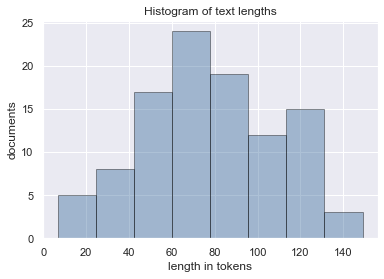

In [24]:
sns.distplot([len(t) for t in texts],
             hist=True, kde=False,
             color = '#336699',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of text lengths')
plt.xlabel('length in tokens')
plt.ylabel('documents')

### Histogram of word occurrence

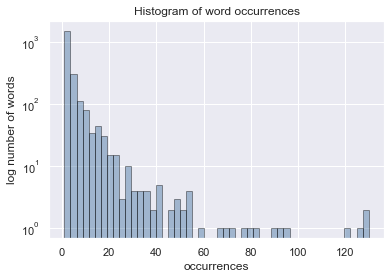

In [25]:
ax = sns.distplot([c for w,c in counts.items()],
                  hist=True, kde=False,
                  color = '#336699',
                  hist_kws={'edgecolor':'black'})

plt.title('Histogram of word occurrences')
plt.xlabel('occurrences')
plt.ylabel('log number of words')
ax.set_yscale('log')

## Add bigrams and trigrams

In [26]:
bigrams = models.Phrases(texts, min_count=3)
trigrams = models.Phrases(bigrams[texts], min_count=3)

In [27]:
texts = [text + [x for x in bigrams[text] if '_' in x]
              + [x for x in trigrams[text] if '_' in x]
         for text in texts]

In [28]:
dictionary = corpora.Dictionary(texts)
bows = [dictionary.doc2bow(text) for text in texts]

## LDA

In [29]:
from gensim.models.ldamodel import LdaModel

In [30]:
%%time
n_topics = 6
lda = LdaModel(bows, id2word=dictionary, num_topics=n_topics,
               alpha='auto', eta='auto',
               iterations=10,
               passes=100,
               eval_every=1)

CPU times: user 8.03 s, sys: 57.7 ms, total: 8.08 s
Wall time: 8.37 s


In [31]:
lda.show_topics()

[(0,
  '0.053*"fibrosi" + 0.052*"cystic_fibrosi" + 0.052*"cystic" + 0.020*"cf" + 0.013*"lung" + 0.010*"therapi" + 0.009*"cftr" + 0.008*"transmembran_conduct" + 0.008*"gene" + 0.008*"increas"'),
 (1,
  '0.080*"breast_cancer" + 0.058*"tripl_neg" + 0.047*"cancer" + 0.044*"breast" + 0.032*"neg" + 0.030*"tripl" + 0.028*"tnbc" + 0.016*"cell" + 0.015*"express" + 0.015*"tumor"'),
 (2,
  '0.059*"bb" + 0.030*"syndrom" + 0.022*"biedl" + 0.022*"bardet_biedl" + 0.022*"bardet" + 0.018*"genet" + 0.016*"cilia" + 0.015*"qualiti_life" + 0.013*"syndrom_bb" + 0.013*"renal"'),
 (3,
  '0.032*"imperfecta" + 0.031*"osteogenesi_imperfecta" + 0.031*"osteogenesi" + 0.027*"bone" + 0.025*"mutat" + 0.018*"oi" + 0.015*"type" + 0.015*"therapi" + 0.014*"collagen" + 0.012*"fractur"'),
 (4,
  '0.049*"neurofibromatosi" + 0.031*"nf" + 0.031*"ar" + 0.023*"tumor" + 0.014*"neurofibromatosi_type" + 0.013*"inhibit" + 0.012*"spinal_neurofibromatosi" + 0.012*"vegf_express" + 0.012*"segment_neurofibromatosi" + 0.012*"ar_inhibit"'

In [32]:
dtm = np.array([
    [dict(lda.get_document_topics(bow)).get(topic, 0.0) for topic in range(n_topics)]
    for bow in bows
])

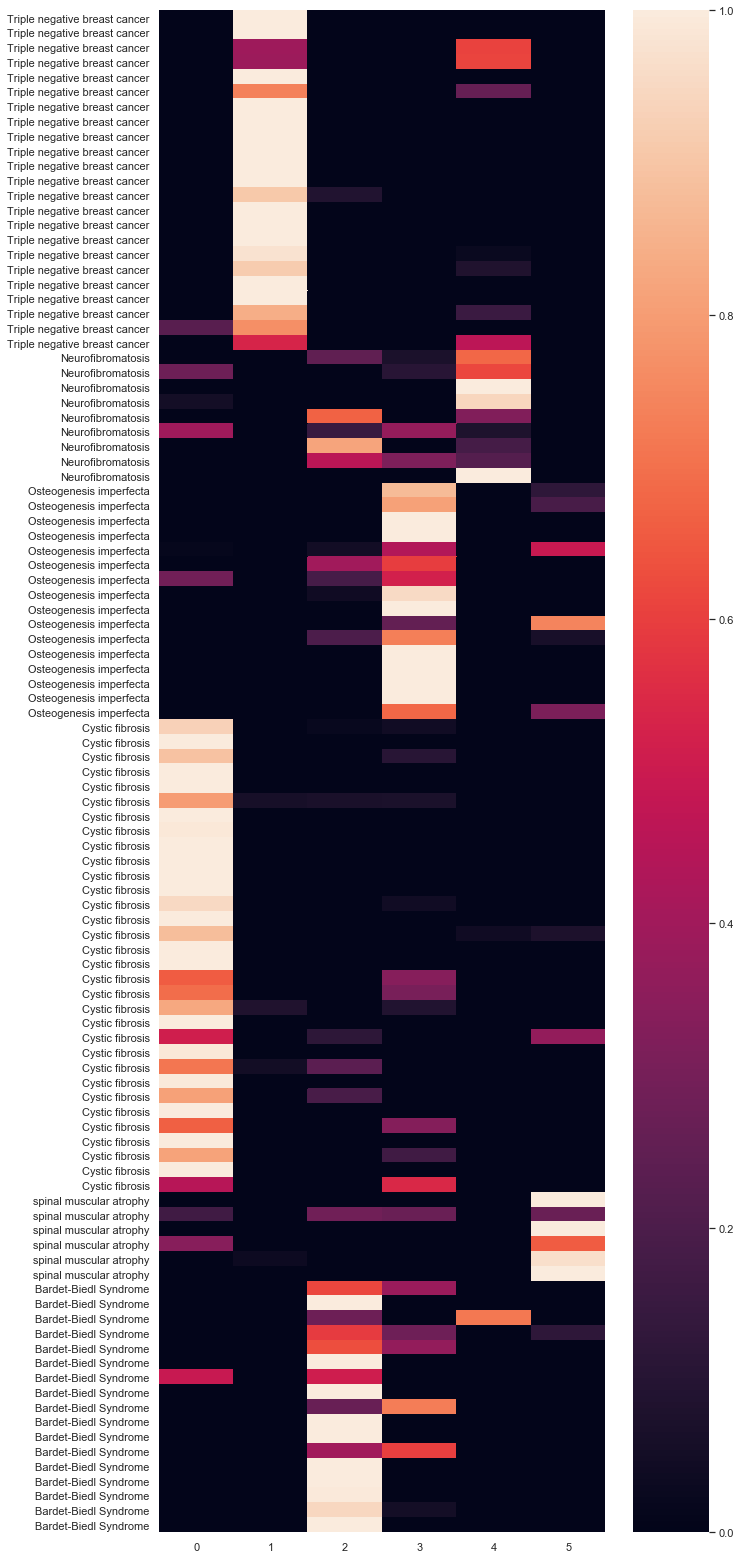

In [33]:
fig, ax = plt.subplots(figsize=(10,28))
ax = sns.heatmap(dtm, vmin=0, vmax=1, ax=ax, yticklabels=labeled_set.topic)

## Coherence measure

In [34]:
coherence_model_lda = CoherenceModel(model=lda,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5404652993152016


## Parameter sweep

In [171]:
texts = [preprocess_string(a.title + ' ' + a.abstract, filters=filters) for a in articles]
wc = Counter(w for t in texts for w in t)

In [163]:
def fit(n_topics, min_occur, iterations, passes, texts, wc):

    bigrams = models.Phrases(texts, min_count=3)
    trigrams = models.Phrases(bigrams[texts], min_count=3)

    texts = [[w for w in t if (len(w)>1 and wc[w]>min_occur)] for t in texts]

    texts = [text + [x for x in bigrams[text] if '_' in x]
                  + [x for x in trigrams[text] if '_' in x]
             for text in texts]

    dictionary = corpora.Dictionary(texts)
    bows = [dictionary.doc2bow(text) for text in texts]

    lda = LdaModel(bows, id2word=dictionary, num_topics=n_topics,
                   alpha='auto', eta='auto',
                   iterations=iterations,
                   passes=passes,
                   eval_every=1)

    coherence_model_lda = CoherenceModel(model=lda,
                                     texts=texts,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

    return Namespace(**locals())

In [57]:
params = [(min_occur, iterations, passes)
            for min_occur in [1, 3, 5, 7, 9, 11, 13, 15]
                for iterations in [10, 20, 30, 50, 70]
                    for passes in [100, 200, 300, 400, 500]
                        for rep in range(3)]
len(params)

600

In [60]:
results = [(min_occur, iterations, passes,
            fit(6, min_occur, iterations, passes, texts, wc))
    for min_occur, iterations, passes in tqdm(params)]

In [61]:
len(results)

600

In [62]:
coh = pd.DataFrame([(m,i,p,fo.coherence) for m,i,p,fo in results],
                   columns=['min-occur', 'iterations', 'passes', 'coherence'])
coh.shape

(600, 4)

In [63]:
coh.head()

,min-occur,iterations,passes,coherence
0,1,10,100,0.516586
1,1,10,100,0.518320
2,1,10,100,0.555980
3,1,10,200,0.554319
4,1,10,200,0.514576


More passes don't seem to help.

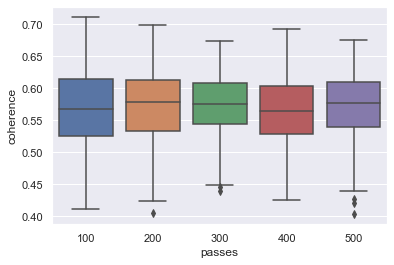

In [64]:
ax = sns.boxplot(x="passes", y="coherence", data=coh)

The iterations parameter is documented as, "_Maximum number of iterations through the corpus when inferring the topic distribution of a corpus._" 50 is the default, although if anything, less seems to be better.

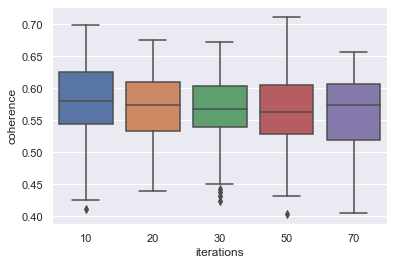

In [65]:
ax = sns.boxplot(x="iterations", y="coherence", data=coh)

Filtering out low-occurrence words seems to help, up to a point around 11 or so. If we filter too aggressively, we risk loosing signal.

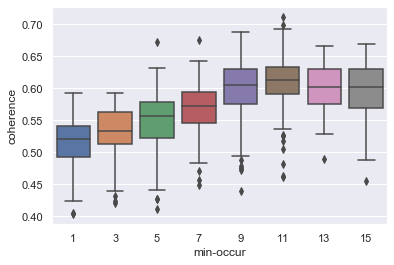

In [66]:
ax = sns.boxplot(x="min-occur", y="coherence", data=coh)

Settling on these as a good set of params, let's look at how much variance we can expect from one run to the next.

In [172]:
m = 11
i = 20
p = 300
results_var = [(m, i, p, fit(6, m, i, p, texts, wc)) for _ in tqdm(range(10))]

### Summary of coherence statistics for 10 models

In [173]:
pd.DataFrame([fo.coherence for m,i,p,fo in results_var], columns=['coherence']).describe()

,coherence
count,10.000000
mean,0.586292
std,0.067618
min,0.469955
25%,0.531439
50%,0.608978
75%,0.644486
max,0.654017


## Look at the highest-scoring of the 10 models

In [174]:
max_coherence = 0.0
max_index = None
for j,(m,i,p,fo) in enumerate(results_var):
    if fo.coherence > max_coherence:
        max_index = j
        max_coherence = fo.coherence
print(max_coherence)

0.6540166981685015


In [175]:
def max_i(a):
    return max(a, key=lambda x: x[1])[0]

In [176]:
m,i,p,best = results_var[max_index]
lda_labels = [max_i(best.lda.get_document_topics(bow)) for bow in best.bows]

In [177]:
best.lda.show_topics()

[(0,
  '0.063*"neurofibromatosi" + 0.037*"smn" + 0.034*"motor_neuron" + 0.032*"nf" + 0.029*"motor" + 0.027*"spinal" + 0.026*"sma" + 0.024*"neurofibromatosi_type" + 0.022*"exon" + 0.021*"includ"'),
 (1,
  '0.051*"imperfecta" + 0.049*"osteogenesi_imperfecta" + 0.049*"osteogenesi" + 0.037*"bone" + 0.031*"oi" + 0.024*"collagen" + 0.023*"mutat" + 0.021*"therapi" + 0.020*"fractur" + 0.018*"caus"'),
 (2,
  '0.086*"fibrosi" + 0.084*"cystic" + 0.084*"cystic_fibrosi" + 0.032*"cf" + 0.021*"lung" + 0.019*"therapi" + 0.015*"cftr" + 0.014*"gene" + 0.013*"transmembran_conduct" + 0.013*"develop"'),
 (3,
  '0.115*"breast_cancer" + 0.082*"tripl_neg" + 0.067*"cancer" + 0.062*"breast" + 0.046*"neg" + 0.042*"tripl" + 0.040*"tnbc" + 0.025*"cell" + 0.025*"tumor" + 0.022*"express"'),
 (4,
  '0.066*"qualiti_life" + 0.049*"type" + 0.038*"qualiti" + 0.038*"life" + 0.036*"oi_type" + 0.031*"long_term" + 0.031*"bisphosphon" + 0.028*"long" + 0.025*"increas" + 0.024*"bone"'),
 (5,
  '0.091*"bb" + 0.042*"syndrom" + 0.

In [178]:
dtm = np.array([
    [dict(best.lda.get_document_topics(bow)).get(topic, 0.0) for topic in range(n_topics)]
    for bow in best.bows
])

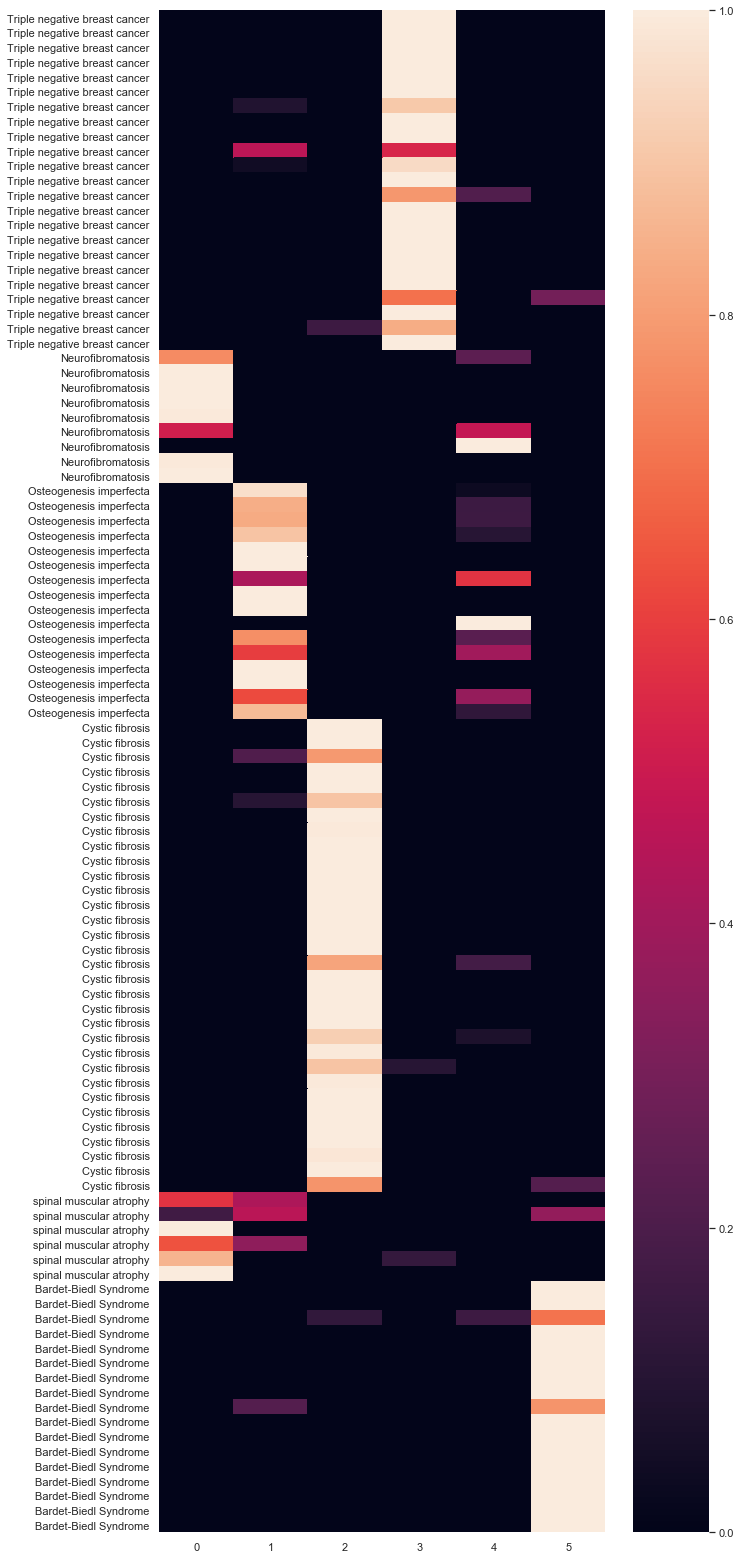

In [179]:
fig, ax = plt.subplots(figsize=(10,28))
ax = sns.heatmap(dtm, vmin=0, vmax=1, ax=ax, yticklabels=labeled_set.topic)

Compute metrics for comparison to k-means model. We have to convert _bows_ into a numpy matrix to compute silhouette score.

In [180]:
X = np.zeros((len(best.bows),len(best.dictionary)))

In [181]:
for i, bow in enumerate(best.bows):
    for j, x in bow:
        X[i,j] = x

In [182]:
from sklearn import metrics

In [183]:
print("Homogeneity: {:0.3f}".format(
            metrics.homogeneity_score(labeled_set.topic, lda_labels)))
print("Completeness: {:0.3f}".format(
            metrics.completeness_score(labeled_set.topic, lda_labels)))
print("V-measure: {:0.3f}".format(
            metrics.v_measure_score(labeled_set.topic, lda_labels)))
print("Adjusted Rand-Index: {:0.3f}".format(
            metrics.adjusted_rand_score(labeled_set.topic, lda_labels)))
print("Silhouette Coefficient: {:0.3f}".format(
            metrics.silhouette_score(X, lda_labels, sample_size=1000)))

Homogeneity: 0.917
Completeness: 0.930
V-measure: 0.923
Adjusted Rand-Index: 0.943
Silhouette Coefficient: 0.121


# Apply LDA to unlabeled set

In [184]:
test_set = pd.read_csv('../data/pmids_test_set_unlabeled.txt', sep='\t',
                             header=None, names=['pmid'])
print(test_set.shape)
test_set.head()

(77, 1)


,pmid
0,8001324
1,12598898
2,14707528
3,17047017
4,17487218


In [185]:
articles_test = fetch_abstracts(test_set.pmid)
len(articles_test)

77

In [186]:
texts_test = [preprocess_string(a.title + ' ' + a.abstract, filters=filters) for a in articles_test]
wc = Counter(w for t in texts_test for w in t)

In [187]:
k = 5
m = 11
i = 20
p = 300
results_test_var = [(m, i, p, fit(k, m, i, p, texts_test, wc)) for _ in tqdm(range(10))]

In [188]:
pd.DataFrame([fo.coherence for m,i,p,fo in results_test_var], columns=['coherence']).describe()

,coherence
count,10.000000
mean,0.499764
std,0.030954
min,0.456092
25%,0.470396
50%,0.511325
75%,0.527142
max,0.529409


In [189]:
max_coherence = 0.0
max_index = None
for j,(m,i,p,fo) in enumerate(results_test_var):
    if fo.coherence > max_coherence:
        max_index = j
        max_coherence = fo.coherence
print(max_coherence)

0.5294092735182563


In [192]:
m,i,p,best = results_test_var[max_index]
lda_labels = [max_i(best.lda.get_document_topics(bow)) for bow in best.bows]

In [193]:
best.lda.show_topics()

[(0,
  '0.074*"lung" + 0.068*"lung_adenocarcinoma" + 0.049*"adenocarcinoma" + 0.036*"express" + 0.034*"surviv" + 0.031*"mutat" + 0.028*"lung_cancer" + 0.025*"cancer" + 0.023*"stage" + 0.022*"luad"'),
 (1,
  '0.132*"turner_syndrom" + 0.073*"syndrom" + 0.072*"turner" + 0.028*"chromosom" + 0.026*"ts" + 0.026*"girl" + 0.025*"chromosom_materi" + 0.021*"risk" + 0.017*"studi" + 0.014*"thyroid"'),
 (2,
  '0.127*"noonan_syndrom" + 0.095*"syndrom" + 0.077*"noonan" + 0.048*"pain" + 0.043*"mutat" + 0.041*"report" + 0.030*"gene" + 0.030*"case" + 0.021*"ns" + 0.021*"noonan_like"'),
 (3,
  '0.112*"lynch_syndrom" + 0.067*"syndrom" + 0.067*"colorect_cancer" + 0.057*"cancer" + 0.057*"lynch" + 0.036*"colorect" + 0.034*"nipbl" + 0.022*"mutat" + 0.020*"test" + 0.019*"mmr"'),
 (4,
  '0.127*"marfan_syndrom" + 0.074*"marfan" + 0.066*"syndrom" + 0.029*"connect_tissu" + 0.026*"aortic" + 0.022*"tissu" + 0.021*"mf" + 0.017*"aortic_aneurysm" + 0.017*"studi" + 0.014*"connect"')]

In [194]:
len(best.dictionary)

199

In [195]:
X = np.zeros((len(best.bows),len(best.dictionary)))
for i, bow in enumerate(best.bows):
    for j, x in bow:
        X[i,j] = x

In [196]:
print("Silhouette Coefficient: {:0.3f}".format(
            metrics.silhouette_score(X, lda_labels, sample_size=1000)))

Silhouette Coefficient: 0.163
